# Import Libraries

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import cv2

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, LeakyReLU, ELU, Tanh, Hardtanh, Hardsigmoid, Sigmoid, CrossEntropyLoss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Dropout2d
from torch.optim import Adam, SGD
from skimage import io
import torch.nn.functional as f

In [2]:
import os
os.uname()

posix.uname_result(sysname='Linux', nodename='lambda-dual', release='5.11.0-27-generic', version='#29~20.04.1-Ubuntu SMP Wed Aug 11 15:58:17 UTC 2021', machine='x86_64')

# Load dataset

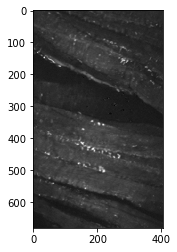

In [3]:
# loading dataset
data_dir = '/home/jessew/engrprojects/WilsonGroup/TuCo/data/20210920 modify SVD_mods_Arya/620nm/'
filenames = os.listdir(data_dir)
# print(filenames)
img_stack = []
for files in filenames:
    img = io.imread(data_dir + files)
    plt.imshow(img[:,:,5], cmap='gray')
#     plt.show()
    img_stack.append(img)

In [4]:
y_reduced = []
y_oxidized = []
y_permeabilized = []
for file in filenames:
    print(file)
    y_reduced.append(file.find("red")!=-1)
    y_oxidized.append(file.find("ox")!=-1)
    y_permeabilized.append(file.find("perm")!=-1)
    
print(y_permeabilized)

20210909_red perm_area 5.tif
20210909_ox perm_area 1.tif
20210909_red perm_area 7.tif
20210909_red perm_area 4.tif
20210909_red intact_area 6.tif
20210909_ox intact_area 5.tif
20210909_ox perm_area 6.tif
20210909_ox intact_area 6.tif
20210909_ox perm_area 2.tif
20210909_red intact_area 4.tif
20210909_red perm_area 8.tif
20210909_red perm_area 6.tif
20210909_ox perm_area 3.tif
20210909_red perm_area 3.tif
20210909_red intact_area 1.tif
20210909_red intact_area 2.tif
20210909_ox perm_area 5.tif
20210909_red perm_area 9.tif
20210909_ox intact_area 4.tif
20210909_red perm_area 10.tif
20210909_ox intact_area 1.tif
20210909_ox intact_area 3.tif
20210909_red intact_area 3.tif
20210909_ox intact_area 2.tif
20210909_red intact_area 5.tif
[True, True, True, True, False, False, True, False, True, False, True, True, True, True, False, False, True, True, False, True, False, False, False, False, False]


In [5]:
# convert images to numpy arrays
img_stack = np.asarray(img_stack)
img_stack = img_stack.astype('float32')
print(img_stack.shape)

(25, 681, 406, 9)


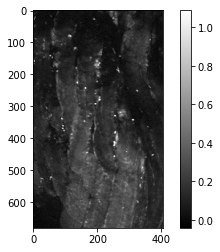

In [6]:
# choose a slice and show
plt.imshow(img_stack[2,:,:,5], cmap = 'gray')
plt.colorbar()
plt.show()

In [7]:
# get image height and width metrics
_, nx, ny, nch = img_stack.shape
print('img width = {}, img height = {}, img channels = {}'.format(nx, ny, nch))

img width = 681, img height = 406, img channels = 9


In [8]:
# prepare the input data before training
"""cuda:0 for GPU 0, cuda:1 for GPU1, cpu for CPU"""
device = 'cuda:0'
print(device)

img_stack = torch.tensor(img_stack)
print(img_stack.shape)
img_stack = img_stack.to(device)

cuda:0
torch.Size([25, 681, 406, 9])


# Define model

In [106]:
class ResnetBlock(Module):
    def __init__(self, channels, kernel_size, stride, padding):
        super(ResnetBlock, self).__init__()
        self.conv = Sequential(
                        Conv2d(in_channels=channels, 
                          out_channels=channels,
                          kernel_size=kernel_size,
                          stride=stride,
                          padding=padding, bias=False) )
        
    def forward(self, x):
        intermediate = self.conv(x)
        out = x + intermediate
        return out
        

class ScalableSat(Module):
    def __init__(self):
        super(ScalableSat, self).__init__()
 
        self.a = nn.parameter.Parameter(torch.Tensor([1.0,1.0,0.0]))
        self.tanh = Tanh()
        
    def forward(self,x):
        return self.a[1]*self.tanh(self.a[0]*x)+self.a[2]
    
class LeakyHardsigmoid(Module):
    def __init__(self, negative_slope=0.1):
        super(LeakyHardsigmoid,self).__init__()
        self.ns = negative_slope
        
    def forward(self,x):
        return f.leaky_relu(-f.leaky_relu(-(x-3)/6,negative_slope=self.ns)+1,negative_slope=self.ns)

class OffsetHardsigmoid(Module):
    def __init__(self):
        super(OffsetHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.hardsigmoid(x-3)

class OffsetLeakyHardsigmoid(Module):
    def __init__(self):
        super(OffsetLeakyHardsigmoid,self).__init__()
        
        
    def forward(self,x):
        return f.rrelu(-f.rrelu(-(x-1),lower=0)+1,lower=0)
    
class AbsActivation(Module):
    def __init__(self):
        super(AbsActivation,self).__init__()
        
    def forward(self,x):
        return torch.abs(x)

class NormalizeEndmembers(Module):
    def forward(self,X):
        return X / X.norm(dim=0)
        
        
nch_bottleneck = 3

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()
        
        # learnable scale and bias after sum of endmembers
        #self.a = nn.parameter.Parameter(torch.Tensor([1,0]))
        self.a = nn.parameter.Parameter(torch.Tensor([1]))

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            #Dropout(p=0.5),
            Conv2d(nch, 64, kernel_size=3, stride=1, padding=1,bias=False),
                        
            # Defining another 2D convolution layer
            Conv2d(64, nch_bottleneck, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Hardtanh(),
            AbsActivation()
        )
        
        """The spectral autoencoder has a bottleneck in the number of channels instead of upsampling and downsampling layers"""
        self.cnn_spectral_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(nch_bottleneck, nch, kernel_size=1, stride=1,bias=False),
            ScalableSat()
        )
        
        nn.utils.parametrize.register_parametrization(self.cnn_spectral_layers[0],"weight",NormalizeEndmembers())
        
        self.bypass_layers = Sequential(
            nn.AdaptiveAvgPool2d(1), # shrink 1 x nch x ny x nx stack to 1 x nch x 1 x 1 average signal
            Conv2d(nch,128,kernel_size=1,stride=1,bias=False), # expand into features
            Sigmoid(),
            Conv2d(128,128,kernel_size=1,stride=1,bias=False), # expand into features
            Sigmoid(),
            Conv2d(128, nch_bottleneck, kernel_size=1,stride=1,bias=False), # squeeze to spectral bottleneck
            #OffsetHardsigmoid() # match bottleneck nonlinearity
            nn.RReLU(lower=0)
            )

    def getSOEMlayer(self):
        return self.cnn_spectral_layers[0]
    
    # Defining the forward pass    
    def forward(self, x):
        z = self.cnn_layers(x)
        #x = self.a[0]*self.cnn_spectral_layers(x) + self.a[1]
        #x = self.a*self.cnn_spectral_layers(x)
        x = self.cnn_spectral_layers(x)
        return x
    
    def forward_enc(self, x):
        z = self.cnn_layers(x)
        return z
    
    def forward_bypass(self,x):
        z = self.bypass_layers(x)
        return z
    
    def forward_dec(self, z):
        
        #if torch.rand(1) > 0.99:
        #z = z + 0.01*torch.randn_like(z)
        #z = f.relu(z)
        #y = self.a*self.cnn_spectral_layers(z)
        #y = self.a[0]*self.cnn_spectral_layers(z) + self.a[1]
        y = self.cnn_spectral_layers(z)
        return y

In [107]:
# instantiate the model by calling the function
model = Net()
print(model)
# set the model training device
model.to(device) # load the model in the training device



Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardtanh(min_val=-1.0, max_val=1.0)
    (3): AbsActivation()
  )
  (cnn_spectral_layers): Sequential(
    (0): ParametrizedConv2d(
      3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): NormalizeEndmembers()
        )
      )
    )
    (1): ScalableSat(
      (tanh): Tanh()
    )
  )
  (bypass_layers): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Conv2d(9, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Sigmoid()
    (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): Sigmoid()
    (5): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): RReLU(lower=0, upper=0.3333333333333333)
  )
)


Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Hardtanh(min_val=-1.0, max_val=1.0)
    (3): AbsActivation()
  )
  (cnn_spectral_layers): Sequential(
    (0): ParametrizedConv2d(
      3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): NormalizeEndmembers()
        )
      )
    )
    (1): ScalableSat(
      (tanh): Tanh()
    )
  )
  (bypass_layers): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Conv2d(9, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Sigmoid()
    (3): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): Sigmoid()
    (5): Conv2d(128, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): RReLU(lower=0, upper=0.3333333333333333)
  )
)

In [28]:
images = img_stack[1]
images = images[None, :]
image_x_p = torch.permute(images, (0, 3, 1, 2))
image_x_p = image_x_p.to(device)

z = model.forward_bypass(image_x_p)
print(z.shape)

y = model.forward_dec(z)
print(y.shape)

torch.Size([1, 3, 1, 1])
torch.Size([1, 9, 1, 1])


In [22]:
# define loss function
criterion_L1 = nn.L1Loss()
criterion_L2 = nn.MSELoss()



In [23]:
# define latent space visualization function
def visualize_z(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,:,:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(1.2*img[:,:,0:3])
    plt.show()
    return img

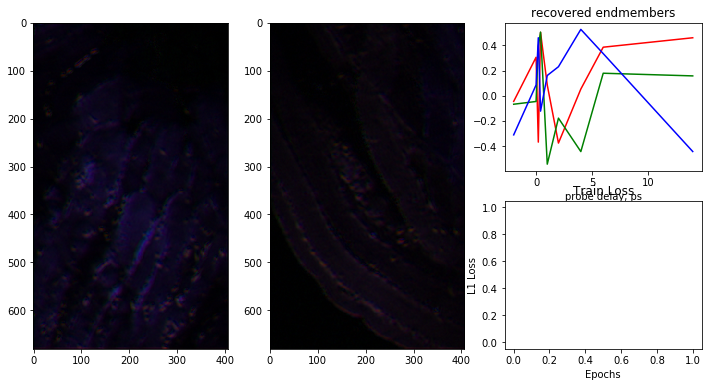

In [92]:
# define latent space visualization function
def generate_z_image(ind):
    data = img_stack[ind,:,:,:]
    data = data[None,:]
    data = data.to(device)
    out = model.forward_enc(torch.permute(data, (0, 3, 1, 2)))
    out = out[0,indices[0:3],:,:]
    out = torch.permute(out, (1,2,0))
    img = out.detach().cpu().numpy()
    return 1.*img

def visualSummary():
    plt.figure(figsize=(12,6))
    plt.subplot(2,3,(1,4))
    img = generate_z_image(0)
    plt.imshow(img)
    plt.subplot(2,3,(2,5))
    img = generate_z_image(1)
    plt.imshow(img)
    plt.subplot(2,3,3)
    w = model.getSOEMlayer().weight
    w = w.detach().cpu().numpy().squeeze()
    tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
    plt.plot(tau,w[:,indices[0]],'r')
    plt.plot(tau,w[:,indices[1]],'g')
    plt.plot(tau,w[:,indices[2]],'b')
    plt.title('recovered endmembers')
    plt.xlabel('probe delay, ps')
    plt.subplot(2,3,6)
    plt.plot(L1_loss)
    #plt.semilogy()
    plt.title('Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('L1 Loss')
    
    plt.show()
    

visualSummary()

# Experiment with variance ordering loss

In [14]:
# Custom Loss Functions

def meansq(x):
    return torch.mean((x-torch.mean(x))**2)

def corr(x,y):
    return torch.sum(x*y) / (torch.sqrt(torch.sum(x**2))*torch.sqrt(torch.sum(y**2)))

def SADLoss(weights):
    deriv = torch.nn.Parameter(weights[1:,]-weights[:-1,])
    sad = torch.sum(deriv**2)
    return sad

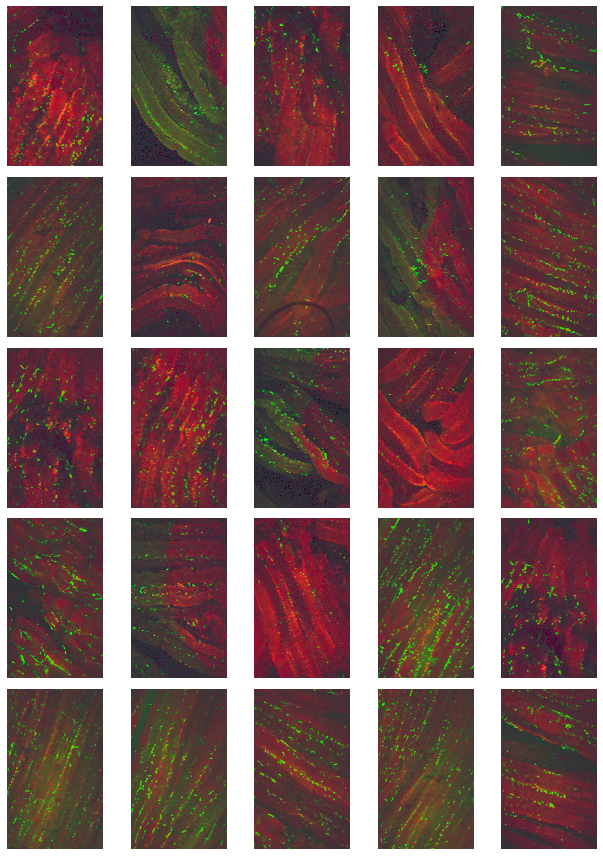

In [42]:

plt.figure(figsize=(9,12))

for i in range(len(img_stack)):
    plt.subplot(5,5,i+1)
    img = generate_z_image(i)
    plt.imshow(img**.8)
    plt.axis(False)

plt.tight_layout()
plt.show()
    

# Train model

  2%|▏         | 49/2000 [00:09<06:08,  5.29it/s]

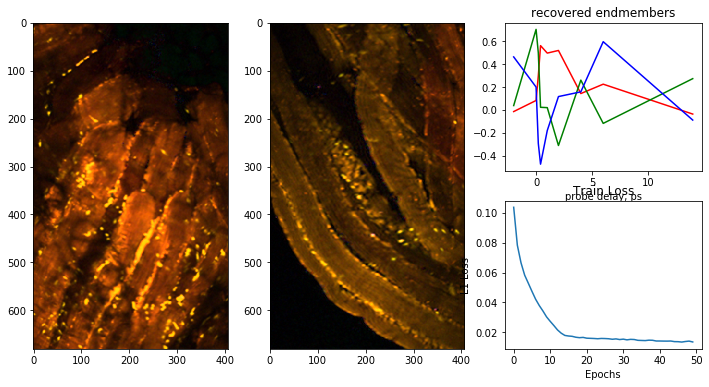

  5%|▍         | 99/2000 [00:19<05:58,  5.30it/s]

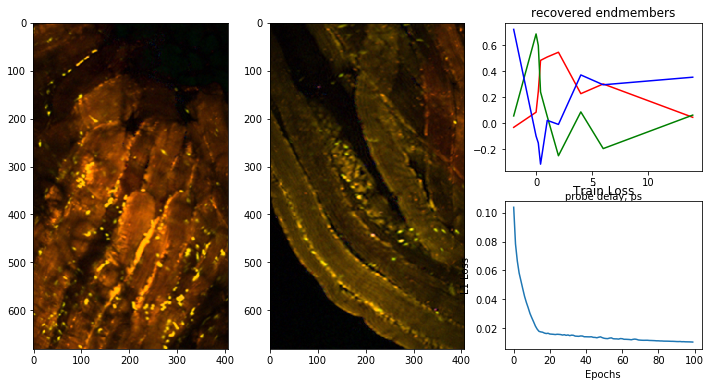

  7%|▋         | 149/2000 [00:28<05:50,  5.29it/s]

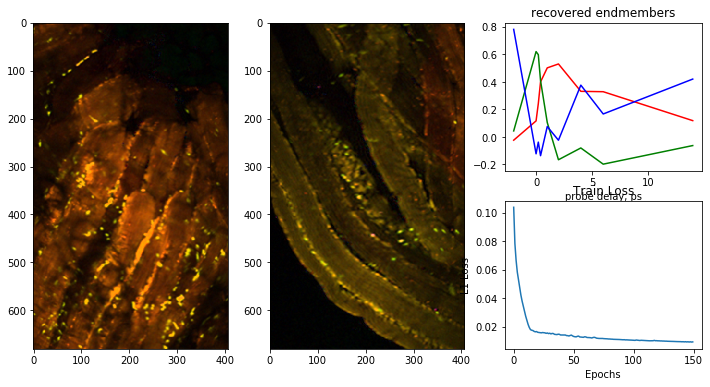

 10%|▉         | 199/2000 [00:38<05:40,  5.29it/s]

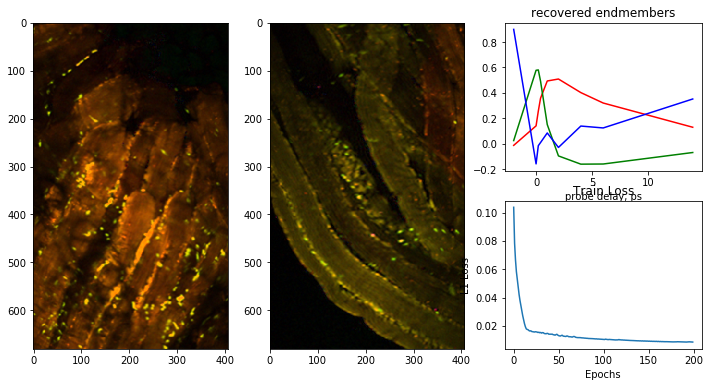

 12%|█▏        | 249/2000 [00:48<05:33,  5.26it/s]

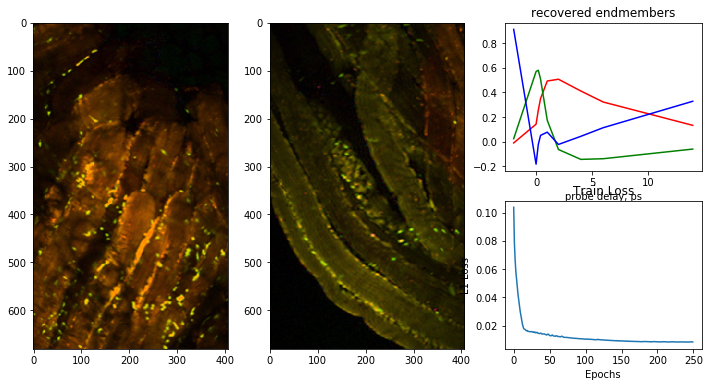

 15%|█▍        | 299/2000 [00:58<05:22,  5.28it/s]

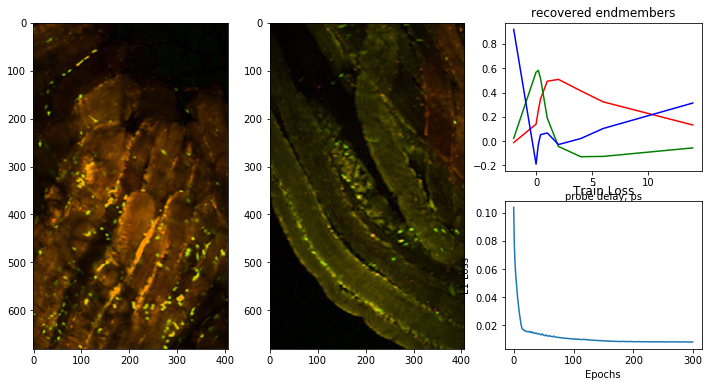

 17%|█▋        | 349/2000 [01:08<05:11,  5.30it/s]

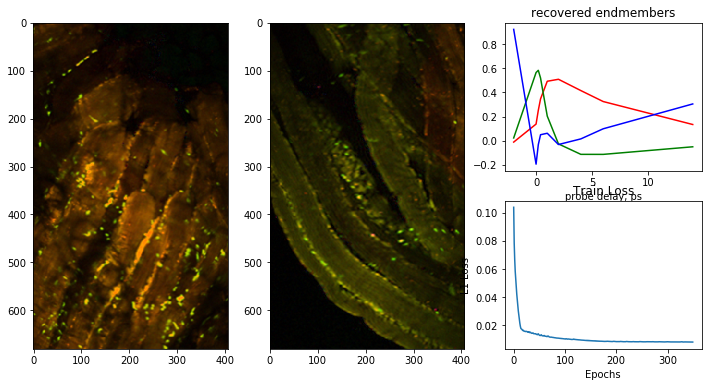

 20%|█▉        | 399/2000 [01:18<05:02,  5.29it/s]

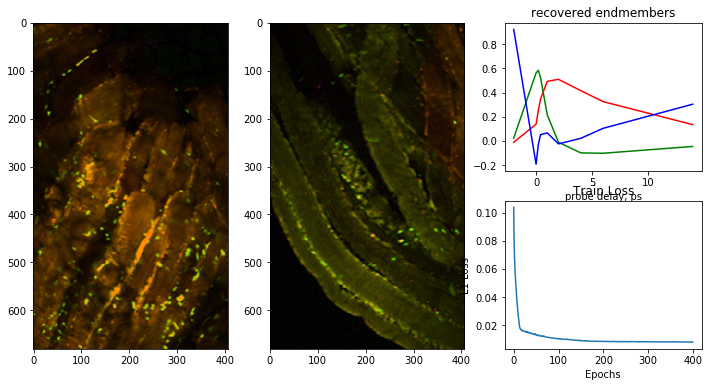

 21%|██▏       | 429/2000 [01:24<05:08,  5.09it/s]


KeyboardInterrupt: 

In [108]:
n_epochs = 2000
L1_loss = []
z_imgs = []


optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

scheduler = None
#scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=.01,steps_per_epoch=len(img_stack),epochs=n_epochs)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100*len(img_stack))



for epoch in tqdm(range(1, n_epochs+1)):
    # monitor training loss
    train_loss = 0.0
    
    # keep track of meansq value for each channel
    channelmsq = torch.zeros(nch_bottleneck).to(device)
    
    #Training
    for i, images in enumerate(img_stack):
        images = images[None, :]
        image_x_p = torch.permute(images, (0, 3, 1, 2))
        image_x_p = image_x_p.to(device)
        optimizer.zero_grad()         
        #outputs = model(image_x_p)
        z = model.forward_enc(image_x_p)
        outputs = model.forward_dec(z)
        
        # run averaged spectra through bypass
        #x_avg = torch.mean(image_x_p,(2,3),keepdim=True)
        #z_bypass = model.forward_bypass(image_x_p)
        #out_bypass = model.forward_dec(z_bypass)
        
        # z-space regularization
        #loss_z_l1 = torch.mean(torch.abs(z))
        #loss_z_l0 = torch.mean((torch.abs(z)>0.01).double())
        
        # categorical losses
        loss_z_cat = 0
        
        if not y_reduced[i]:
            loss_z_cat += torch.mean(abs(z[:,0,:,:]))
        if not y_oxidized[i]:
            loss_z_cat += torch.mean(abs(z[:,1,:,:]))
        if y_permeabilized[i]:
            loss_z_cat += torch.mean(abs(z[:,2,:,:]))
        
        # reconstruction loss
        loss_recon = criterion_L1(outputs, image_x_p)
        #loss_bypass = criterion_L1(out_bypass, x_avg)
        
        # mse image entropy loss
        mseimage = torch.mean( (image_x_p - outputs)**2,dim=(0,1) )
        mseimage = mseimage / torch.sum(mseimage)
        #loss_mse_negentropy = torch.mean(mseimage*torch.log(mseimage))
        loss_mse_negentropy = (torch.mean(mseimage*torch.log(mseimage))+4.5318e-5)*1e5
        
        # variance-ordering
        channelmsq += torch.mean(z**2,dim=[2,3]).squeeze()
        
        
        # interchannel correlation loss
        zvec = z.squeeze().view(nch_bottleneck,-1)
        zvec = zvec-torch.mean(zvec,1,keepdim=True)
        zcov = torch.matmul(zvec,zvec.transpose(0,1))
        zstds = torch.sqrt(zcov.diag()).expand(1,-1)
        zstdprods = torch.matmul(zstds.transpose(0,1),zstds)
        zcorrabs = zcov / (zstdprods + 1e-6)
        #zcorrabs = zcov / zvec.shape[1]
        loss_zcorr = (torch.sum(f.relu(zcorrabs.triu())) - zcorrabs.trace())
        

        
        
        # endmember correlation loss
        w = model.getSOEMlayer().weight
        #ws = w.squeeze()
        #wcorrabs = torch.abs(torch.matmul(ws.transpose(0,1),ws))
        #loss_corr = torch.sum(wcorrabs.triu())-wcorrabs.trace()
        
        # information entropy loss
        #loss_entropy = torch.mean(z*torch.log(z))
        
        emnorms = w.norm(dim=0)
        loss_emnorm = criterion_L1(emnorms,torch.ones_like(emnorms))
        
        # total loss
        #loss = loss_recon + 1e-3*loss_emnorm + 1e-2*loss_zcorr
        loss = loss_recon + 1e-3*loss_zcorr
        #loss = loss_bypass
        
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        train_loss += loss.item()*image_x_p.size(0)
        #train_loss += loss_zcorr.item()
        
        
          
    train_loss = train_loss/len(img_stack)
    #print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
    L1_loss.append(train_loss)
    
    
    # rearrange channels so red has max variance, blue the least
    indices = channelmsq.argsort(descending=True)
    #indices = [0,1,2]
    #print(indices)
    #if(indices[0]!=0 or indices[1]!=1 or indices[2]!=2):
    #    print('shuffle channels; resetting optimizer')
        #optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        
    #    w0 = model.cnn_spectral_layers[1].weight
    #    w = w0[:,indices,:,:]
    #    model.cnn_spectral_layers[1].weight = torch.nn.Parameter(w)

    #    w0 = model.cnn_layers[8].weight
    #    w = w0[indices,:,:,:]
    #    model.cnn_layers[8].weight = torch.nn.Parameter(w)
    
    if epoch%50 == 0:
        # visualize latent space
        visualSummary()
        
        #temp_img = visualize_z(3)
        
        #z_imgs.append(temp_img)
        # plot loss curve
        
        #plt.show()

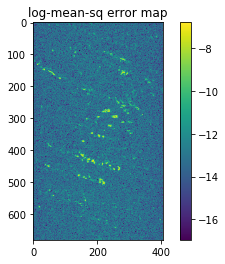

tensor(0.4826, device='cuda:0', grad_fn=<MulBackward0>)


In [87]:
mseimage = torch.mean( (image_x_p - outputs)**2,dim=(0,1) )
#mseimage = torch.ones_like(mseimage)
mseimage = mseimage/torch.sum(mseimage)
plt.imshow(torch.log(mseimage).squeeze().detach().cpu().numpy())
plt.colorbar()
plt.title('log-mean-sq error map')
plt.show()
print((torch.mean(mseimage*torch.log(mseimage))+4.5318e-5)*1e5)

In [74]:
1e4*loss_mse_negentropy

tensor(-0.4049, device='cuda:0', grad_fn=<MulBackward0>)

In [75]:
mseimage = torch.mean( (image_x_p - outputs)**2,dim=(0,1) )


tensor([[2.7514e-05, 2.9947e-05, 1.7759e-05,  ..., 1.1833e-05, 1.8976e-05,
         5.6614e-05],
        [5.6524e-06, 2.5519e-05, 2.8262e-05,  ..., 1.0943e-05, 3.4155e-05,
         3.8080e-05],
        [1.7574e-05, 7.0011e-06, 1.5142e-05,  ..., 1.6211e-05, 2.5013e-05,
         2.1200e-05],
        ...,
        [2.0009e-05, 1.2565e-05, 1.0197e-05,  ..., 5.9707e-06, 1.5467e-05,
         8.2643e-06],
        [1.4197e-05, 1.5462e-05, 1.1326e-05,  ..., 1.0809e-05, 1.0189e-05,
         2.3629e-05],
        [1.1333e-05, 2.0449e-05, 4.9568e-05,  ..., 2.4370e-05, 5.1166e-06,
         2.7684e-05]], device='cuda:0', grad_fn=<MeanBackward1>)

tensor([[[[-0.0212]],

         [[ 0.7539]],

         [[-0.0032]]]], device='cuda:0', grad_fn=<RreluWithNoiseBackward0>)


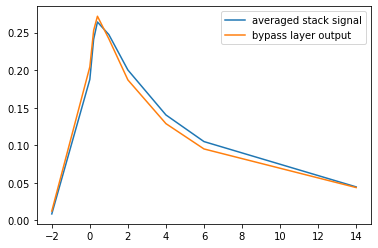

In [112]:
print(z_bypass)
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
plt.plot(tau,x_avg.squeeze().cpu().numpy(),tau,out_bypass.detach().squeeze().cpu().numpy())
plt.legend(['averaged stack signal','bypass layer output'])
plt.show()

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Conv2d(9, 64, kernel_size=(1, 1), stride=(1, 1))
  (2): Sigmoid()
  (3): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
  (4): OffsetHardsigmoid()
)
torch.Size([1, 9, 1, 1])


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

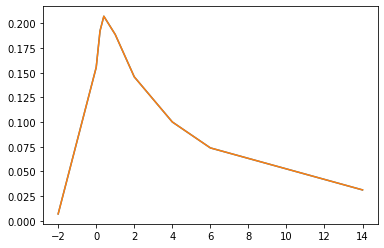

In [79]:
print(model.bypass_layers)
print(model.bypass_layers[0](image_x_p).shape)
plt.plot(tau,x_avg.squeeze().cpu().numpy(),tau,model.bypass_layers[0](image_x_p).squeeze().detach().cpu().numpy())
plt.plot


tensor([[[[0.]],

         [[0.]],

         [[0.]]]], device='cuda:0', grad_fn=<HardsigmoidBackward>)


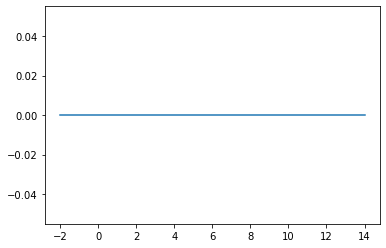

In [59]:
print(z_bypass)
plt.plot(tau,model.cnn_spectral_layers[1](z_bypass).squeeze().detach().cpu().numpy())

In [52]:
model.cnn_spectral_layers[1]

Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1), bias=False)

# Analyze latent space images

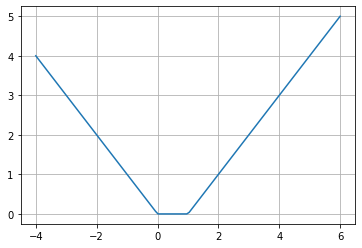

In [81]:
x=torch.linspace(-4,6,128)
y = torch.abs(torch.min(x,torch.Tensor([0])) + torch.max(x,torch.Tensor([1]))-1)



plt.plot(x.numpy(),y.numpy())
plt.grid()
plt.show()

In [211]:
y_permeabilized

[True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False]

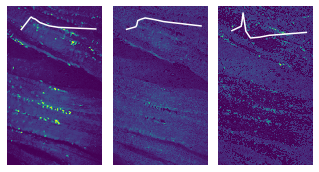

In [64]:
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
plt.figure(figsize=(6,9))
for iz in range(nch_bottleneck):
    plt.subplot(3,4,iz+1)
    plt.imshow(z[0,indices[iz],:,:].squeeze().detach().cpu().numpy())
    plt.plot(20*tau+100,100-100*w[:,indices[iz]].squeeze().detach().cpu().numpy(),'w')
    plt.axis(False)
plt.tight_layout()    
plt.show()


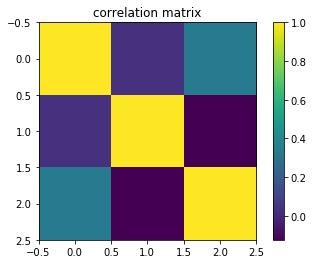

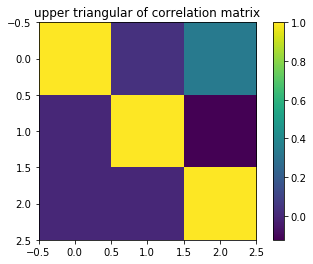

tensor(0.3749, device='cuda:0', grad_fn=<SubBackward0>)

In [69]:
zvec = z.squeeze().view(nch_bottleneck,-1)

zvec = zvec-torch.mean(zvec,1,keepdim=True)
zcov = torch.matmul(zvec,zvec.transpose(0,1))
zstds = torch.sqrt(zcov.diag()).expand(1,-1)
zstdprods = torch.matmul(zstds.transpose(0,1),zstds)
zcorrabs = zcov / (zstdprods + 1e-6)

plt.imshow(zcorrabs.detach().cpu().numpy())
plt.colorbar()
plt.title('correlation matrix')
plt.show()

plt.imshow(zcorrabs.triu().detach().cpu().numpy())
plt.title('upper triangular of correlation matrix')
plt.colorbar()
plt.show()

torch.sum(f.relu(zcorrabs.triu())) - zcorrabs.trace()

In [166]:
loss_zcorr

tensor(0.9825, device='cuda:1', grad_fn=<SubBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


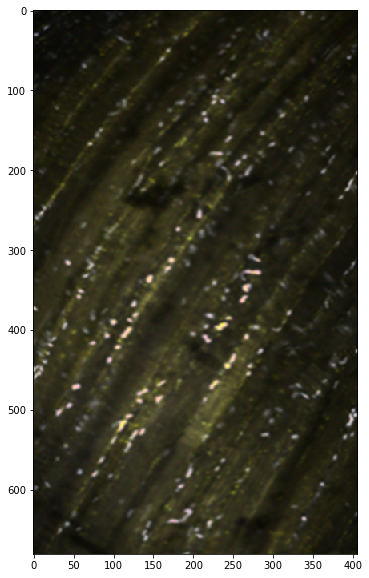

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


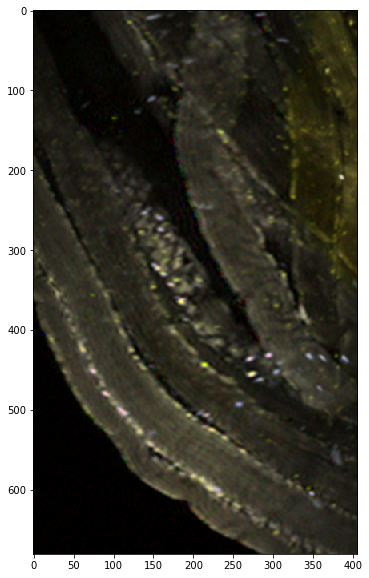

In [224]:
img = visualize_z(5)
img = visualize_z(1)

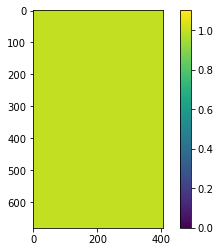

In [51]:
# test
images = img_stack[1]
images = images[None, :]
image_x_p = torch.permute(images, (0, 3, 1, 2))
image_x_p = image_x_p.to(device)
optimizer.zero_grad()         
#outputs = model(image_x_p)
z = model.forward_enc(image_x_p)

z.shape

zsum = torch.sum(z,1)

plt.imshow( zsum.detach().cpu().numpy().squeeze(),vmin=0., vmax=1.1 )
plt.colorbar()
plt.show()



In [26]:
img_stack[1]

tensor([[[ 9.3201e-03,  1.5979e-02,  1.0860e-02,  ...,  1.2023e-03,
          -1.1927e-02,  4.7328e-04],
         [ 6.9301e-03,  1.1901e-02,  7.1274e-03,  ...,  5.5700e-03,
          -9.7670e-03,  3.4160e-03],
         [ 3.7467e-03,  8.1204e-03,  1.3716e-02,  ...,  5.6694e-03,
          -2.5224e-03,  1.6174e-03],
         ...,
         [ 9.2323e-04,  5.1352e-02,  6.9349e-02,  ...,  4.5247e-02,
           3.3827e-02,  2.0773e-02],
         [ 1.0497e-02,  5.2857e-02,  6.7425e-02,  ...,  4.3076e-02,
           4.2239e-02,  2.4767e-02],
         [ 7.9035e-03,  6.1996e-02,  6.6521e-02,  ...,  4.0352e-02,
           3.8618e-02,  1.9000e-02]],

        [[ 5.9691e-03,  1.3551e-02,  1.0695e-02,  ..., -2.5196e-03,
          -4.0417e-03,  1.0264e-04],
         [ 1.0571e-02,  1.4248e-02,  1.2113e-02,  ...,  1.2439e-02,
          -9.5483e-03,  4.5957e-03],
         [ 1.4877e-02,  5.4159e-03,  1.7780e-02,  ...,  1.9610e-02,
          -5.7645e-03,  2.8374e-03],
         ...,
         [ 1.4204e-03,  5

In [15]:
z_imgs = np.asarray(z_imgs)
print(z_imgs.shape)

(4, 681, 406, 3)


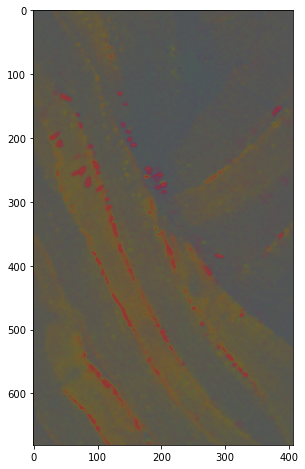

In [24]:
plt.figure(figsize=(8,8))
plt.imshow(z_imgs[2,:,:,:])
plt.show()

In [ ]:
# iterate through the latent space image stack and save the images
n_count = 0
for img in z_imgs:
    io.imsave('img' + str(n_count) + '.png', img)
    n_count = n_count + 1

In [ ]:
# use the saved latent space images to create a movie
image_folder = '/home/arya1080/python_projects/CNN_TAM'
video_name = 'video.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [14]:
# examine model weights

In [15]:
model

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
    (9): Sigmoid()
    (10): Softmax(dim=1)
  )
  (cnn_spectral_layers): Sequential(
    (0): Conv2d(3, 9, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [235]:
x=np.array([1/2, 1/4, 1/4])
np.sum(x**2)

0.375

In [866]:
emnorms = model.cnn_spectral_layers[1].weight.norm(dim=0)
torch.ones_like(emnorms)

tensor([[[1.]],

        [[1.]],

        [[1.]]], device='cuda:1')

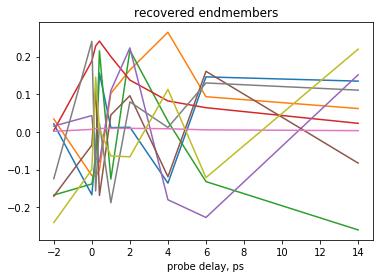

In [1336]:
w = model.cnn_spectral_layers[1].weight
w = w.detach().cpu().numpy().squeeze()
tau=np.array([-2,0,0.2,0.4,1,2,4,6,14])
plt.plot(tau,w)
plt.title('recovered endmembers')
plt.xlabel('probe delay, ps')
plt.show()

In [1078]:
w = model.cnn_spectral_layers[0].weight
print(w[:-1,:,:,:].shape)
print(w[1:,:,:,:].shape)

print((w[1:,]-w[:-1,]).shape)
plt.plot(tau[1:],(w[1:,]-w[:-1,]).detach().cpu().numpy().squeeze())
print(torch.sum(torch.abs(w[1:,]-w[:-1,])))

print(SADLoss(model.cnn_spectral_layers[0].weight))

AttributeError: 'Dropout2d' object has no attribute 'weight'

In [629]:
print(SADLoss(model.cnn_spectral_layers[0].weight))

tensor(9.4268, device='cuda:1', grad_fn=<SumBackward0>)


In [1107]:
w=model.cnn_spectral_layers[1].weight.squeeze()
print(w.transpose(0,1).shape)
wcorrabs = torch.abs(torch.matmul(w.transpose(0,1),w))
print(wcorrabs)
print(torch.sum(wcorrabs.triu())-wcorrabs.trace())


torch.Size([3, 9])
tensor([[0.6331, 0.5815, 0.0047],
        [0.5815, 1.0036, 0.0448],
        [0.0047, 0.0448, 0.9978]], device='cuda:1', grad_fn=<AbsBackward>)
tensor(0.6310, device='cuda:1', grad_fn=<SubBackward0>)


In [685]:
torch.sum(model.cnn_spectral_layers[0].weight**2)

tensor(2.4952, device='cuda:1', grad_fn=<SumBackward0>)